In [1]:
%load_ext autoreload
%autoreload 2 

## Imports

In [2]:
import pandas as pd
from cts_recommender.settings import get_settings
from cts_recommender.logging_setup import setup_logging
from cts_recommender.io import readers
from cts_recommender.environments.TV_environment import TVProgrammingEnvironment
from cts_recommender.models.audience_ratings_regressor import AudienceRatingsRegressor
from cts_recommender.imitation_learning.IL_training import HistoricalDataProcessor

cfg = get_settings()

setup_logging("INFO")

## Open Data and Load environment

In [3]:
catalog_df = readers.read_parquet(cfg.processed_dir / "whatson" / "whatson_catalog.parquet")
historical_programming_df = readers.read_parquet(cfg.processed_dir / "programming" / "historical_programming.parquet")
audience_model = AudienceRatingsRegressor()
audience_model.load_model(cfg.models_dir / "audience_ratings_model.joblib")

2025-10-15 14:55:05 INFO cts_recommender.models.audience_ratings_regressor: Model loaded from data/models/audience_ratings_model.joblib with 67 features


In [4]:
env = TVProgrammingEnvironment(catalog_df, historical_programming_df, audience_model)

2025-10-15 14:55:05 INFO cts_recommender.environments.TV_environment: Setting up CompetitorDataManager...
2025-10-15 14:55:05 INFO cts_recommender.environments.TV_environment: Setting up Scalers...
2025-10-15 14:55:05 INFO cts_recommender.environments.TV_environment: Setting up RewardCalculator...
2025-10-15 14:55:05 INFO cts_recommender.environments.reward: RewardCalculator initialized successfully.


## Test competition

In [5]:
movie_competitor_context = env.competitor_manager.get_movie_competitor_context('762504', reference_date=pd.Timestamp('2024-07-17'))
RTS_programming_instance = env.interest_historical_programming_df[env.interest_historical_programming_df['catalog_id'] == '762504']
print(f"Movie title: {env.catalog_df.loc['762504', 'title']}")
print(f"RTS showing:       {RTS_programming_instance[['channel', 'date', 'hour']].to_dict(orient='records')}")
print(f"Competing showing: {movie_competitor_context.competitor_showings}")

Movie title: Nope 
RTS showing:       [{'channel': 'RTS 1', 'date': Timestamp('2024-07-17 00:00:00'), 'hour': 22}]
Competing showing: [{'channel': 'France 2', 'air_date': Timestamp('2024-07-21 00:00:00'), 'air_hour': 22}]


In [6]:
hist_data_processor = HistoricalDataProcessor(env, 
                                            env.interest_historical_programming_df, 
                                            time_split_date='2024-12-20')


In [7]:
import joblib
training_samples = joblib.load(cfg.processed_dir / "IL" / "training_samples.joblib")
print(f"Loaded {len(training_samples)} training samples")
print(f"Sample keys: {training_samples[0].keys()}")

Loaded 5412 training samples
Sample keys: dict_keys(['context_features', 'movie_features', 'movie_id', 'selected', 'reward', 'value_signals', 'date', 'context_cache_key', 'current_memory'])


## Visualize Reward Signal Distributions

In [8]:
# Extract reward signals from all samples
from cts_recommender.utils.visualization import extract_reward_signals, print_reward_statistics

signals = extract_reward_signals(training_samples)
print_reward_statistics(signals)

Extracted 5412 reward signals

Audience     - range: [0.030, 1.000], mean: 0.571, median: 0.600
Competition  - range: [0.000, 1.000], mean: 0.202, median: 0.200
Diversity    - range: [0.139, 0.695], mean: 0.306, median: 0.283
Novelty      - range: [0.003, 1.000], mean: 0.952, median: 1.000
Rights       - range: [0.000, 1.000], mean: 0.193, median: 0.100


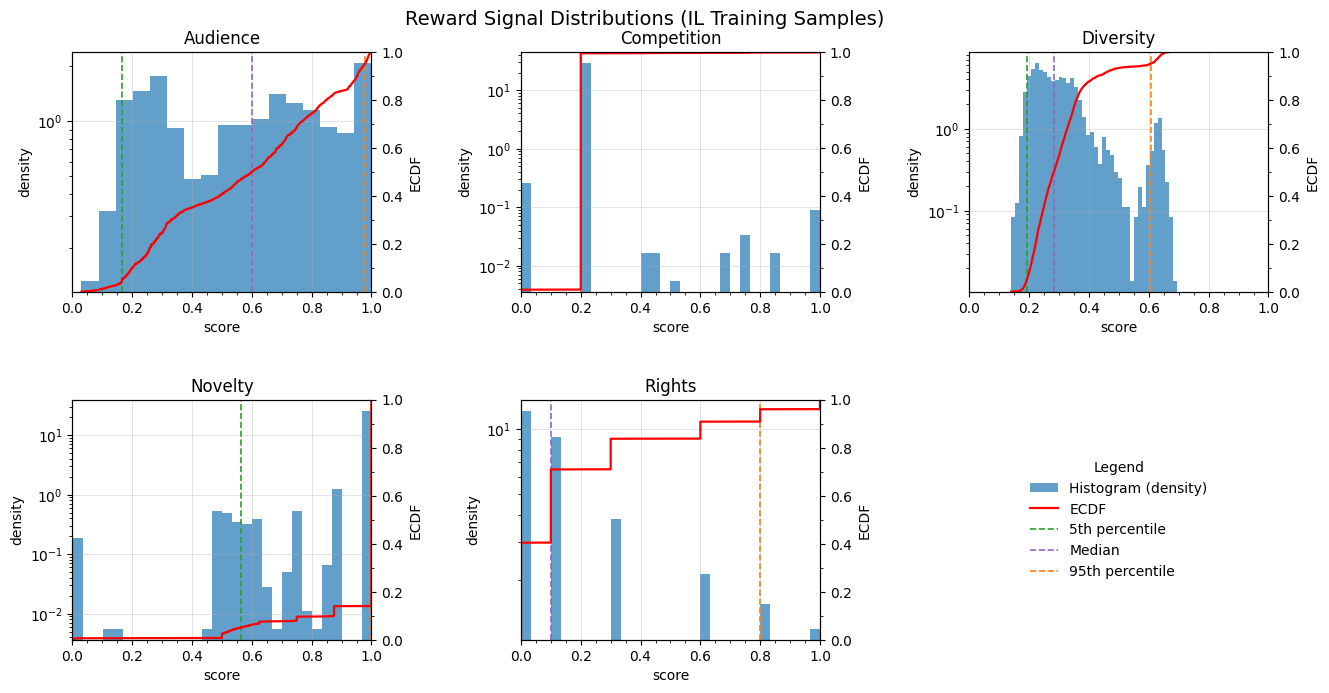

In [9]:
# Create visualization with 5 subplots for each reward component
from cts_recommender.utils.visualization import plot_reward_distributions
import matplotlib.pyplot as plt

# Prepare signals dict with capitalized names for display
signals_display = {
    "Audience": signals['audience'],
    "Competition": signals['competition'],
    "Diversity": signals['diversity'],
    "Novelty": signals['novelty'],
    "Rights": signals['rights'],
}

# Create the plot
fig, axes = plot_reward_distributions(
    signals_display,
    title="Reward Signal Distributions (IL Training Samples)"
)
plt.show()

## Training data

In [10]:
import joblib
training_data_file = cfg.processed_dir / "IL" / "training_data.joblib"
training_data = joblib.load(training_data_file)
training_data

{'context_features': array([[0., 0., 1., ..., 0., 0., 1.],
        [0., 0., 1., ..., 0., 0., 1.],
        [0., 0., 1., ..., 0., 0., 1.],
        ...,
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 1.]], shape=(5412, 16), dtype=float32),
 'movie_features': array([[0.        , 0.6896897 , 0.5615859 , ..., 0.        , 1.        ,
         0.        ],
        [0.        , 0.63508373, 0.30639943, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.2972973 , 0.1276325 , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.8797809 , 0.80513847, 0.8930082 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.9109109 , 0.44722396, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.8128128 , 0.23342787, ..., 0.        , 0.        ,
         0.        ]], shape=(5412, 24), dtype=float32),
 'curator_targets': array([1, 0, 0, ..., 0, 0, 0], shape